In [1]:
import torch 
from hnet.train.hnet import train_hnet
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from hnet.models.MLP import MLP 
from hnet.models.HyperNet import HyperNet
from hnet.train.hnet import EnergyDistanceLoss 
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import roc_auc_score

/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tdf = pd.read_csv('../../extdata/meta/targetome__drug_interacts_protein.csv')
tdf.head()

,inhibitor,Symbol,GeneID,targetome_adj_tier,smiles,inchikey,AA
0,ABT-737,BAD,572,TIER_1,CN(C)CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O...,HPLNQCPCUACXLM-PGUFJCEWSA-N,MFQIPEFEPSEQEDSSSAERGLGPSPAGDGPSGSGKHHRQAPGLLW...
1,Palbociclib,CCND1,595,TIER_1,CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCN...,AHJRHEGDXFFMBM-UHFFFAOYSA-N,MEHQLLCCEVETIRRAYPDANLLNDRVLRAMLKAEETCAPSVSYFK...
2,Flavopiridol,CCNT1,904,TIER_1,CN1CCC(C(C1)O)C2=C(C=C(C3=C2OC(=CC3=O)C4=CC=CC...,BIIVYFLTOXDAOV-YVEFUNNKSA-N,MEGERKNNNKRWYFTREQLENSPSRRFGVDPDKELSYRQQAANLLQ...
3,Bortezomib (Velcade),PSMA1,5682,TIER_1,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,GXJABQQUPOEUTA-RDJZCZTQSA-N,MFRNQYDNDVTVWSPQGRIHQIEYAMEAVKQGSATVGLKSKTHAVL...
4,Bortezomib (Velcade),PSMA2,5683,TIER_1,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,GXJABQQUPOEUTA-RDJZCZTQSA-N,MAERGYSFSLTTFSPSGKLVQIEYALAAVAGGAPSVGIKAANGVVL...


In [3]:
smiles = tdf['smiles'].unique().astype(str).tolist()
aas = tdf['AA'].unique().astype(str).tolist()

In [4]:
model_name = "seyonec/ChemBERTa-zinc-base-v1"

max_len = 512
print("Max length of SMILES:", max_len)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).cuda()

batch_size = 250
outputs = []

print('encoding smiles...')
with torch.no_grad():

    for i in range(0, len(smiles), batch_size):
        print(f"Processing batch {i // batch_size + 1}/{len(smiles) // batch_size + 1}", end="\r")
        smiles_batch = smiles[i:i+batch_size] 
        
        inputs = tokenizer(
            smiles_batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_len  # Adjust max_length as needed
        )

        inputs = {k: v.cuda() for k, v in inputs.items()}
        batch_outputs = model(**inputs)
        outputs.append(batch_outputs.last_hidden_state[:, 0, :].cpu())

# Concatenate all batch outputs
z_drug = torch.cat(outputs, dim=0)
print()

print(z_drug.shape)

Max length of SMILES: 512
encoding smiles...
Processing batch 1/1
torch.Size([89, 768])


In [5]:
model_name = "Rostlab/prot_bert"

tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
model = AutoModel.from_pretrained(model_name)

def prepare_sequence(seq):
    seq = ' '.join(list(seq))
    return f"[CLS] {seq} [SEP]"

sequences_prepared = [prepare_sequence(seq) for seq in aas]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

batch_size = 25
max_len = 1500
outputs = []
for i in range(0, len(aas), batch_size):
    print(f'progress: {i}/{len(aas)}', end='\r')

    inputs = tokenizer(
        sequences_prepared[i:i+batch_size],
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_len  # Adjust as needed
    )

    batch_inputs = {key: value.cuda() for key, value in inputs.items()}
    with torch.no_grad():
        batch_outputs = model(**batch_inputs)
    outputs.append(batch_outputs.last_hidden_state[:, 0, :].cpu())
    torch.cuda.empty_cache()
    
z_prot = torch.cat(outputs, dim=0)
print(z_prot.shape)

torch.Size([214, 1024])


In [6]:
smiles2idx = {smile: i for i, smile in enumerate(smiles)}
aas2idx = {aa: i for i, aa in enumerate(aas)}

tdf = tdf.assign(drug_idx=tdf.smiles.map(smiles2idx))
tdf = tdf.assign(prot_idx=tdf.AA.map(aas2idx))

In [7]:
model = torch.load('model.pt').cpu()

/tmp/ipykernel_28026/2890264594.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pt').cpu()


In [8]:
#rand_drug_idx = torch.randint(0, len(smiles), size=(1000,), dtype=torch.long)
#rand_prot_idx = torch.randint(0, len(aas), size=(1000,), dtype=torch.long)

drug_idx = torch.tensor(tdf.drug_idx.values, dtype=torch.long)
prot_idx = torch.tensor(tdf.prot_idx.values, dtype=torch.long)

A = torch.zeros(len(smiles), len(aas))
A[drug_idx, prot_idx] = 1 
Anot = ~(A.bool())
neg_drug_idx, neg_prot_idx = Anot.nonzero(as_tuple=True)

x_pos = torch.cat([z_drug[drug_idx], z_prot[prot_idx]], dim=1).float()
x_neg = torch.cat([z_drug[neg_drug_idx], z_prot[neg_prot_idx]], dim=1).float()

print('# positive samples:', len(x_pos))
print('# negative samples:', len(x_neg))

y = torch.cat([torch.ones(len(tdf)), torch.zeros(x_neg.size(0))], dim=0).float()

with torch.no_grad(): 
    yhat_pos = model(x_pos, samples=100)
    yhat_neg = model(x_neg, samples=100)

yhat = torch.cat([yhat_pos, yhat_neg], dim=1)

# positive samples: 422
# negative samples: 18624


In [9]:
auc = roc_auc_score(y.detach().numpy(), yhat.mean(0).detach().numpy())
print(f'AUC: {auc}')

AUC: 0.46924877037833257


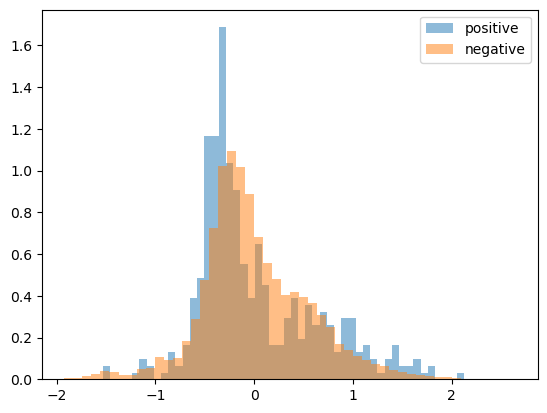

In [10]:
plt.figure()
plt.hist(yhat_pos.cpu().mean(dim=0).numpy(), bins=50, alpha=0.5, label='positive', density=True)
plt.hist(yhat_neg.cpu().mean(dim=0).numpy(), bins=50, alpha=0.5, label='negative', density=True)
plt.legend()
plt.show()

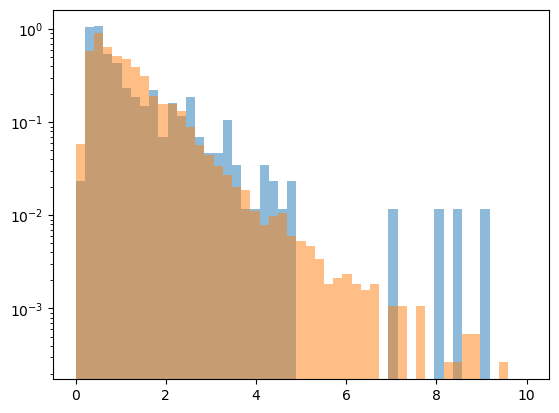

In [11]:
var_pos = yhat_pos.var(dim=0)
var_neg = yhat_neg.var(dim=0)

_bins = np.linspace(0,10, 50)
plt.figure()
plt.hist(var_pos.cpu().numpy(), bins=_bins, label='positive', alpha=0.5, density=True)
plt.hist(var_neg.cpu().numpy(), bins=_bins, label='negative', alpha=0.5, density=True)
plt.yscale('log')
plt.show()

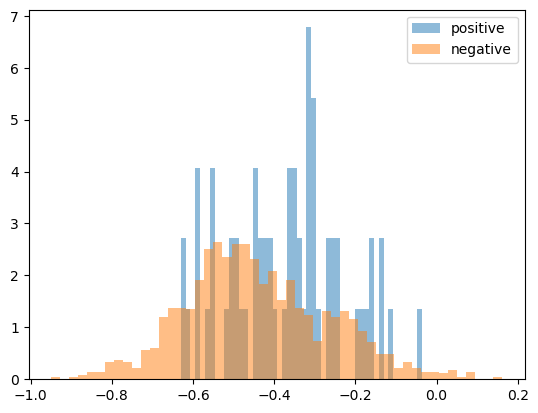

In [12]:
var = yhat.var(dim=0).squeeze()
hi_conf_mask = var < 0.33

y_hi_conf = y[hi_conf_mask]
yhat_hi_conf = yhat.mean(0)[hi_conf_mask]

plt.figure()
plt.hist(yhat_hi_conf[y_hi_conf.bool()].cpu().numpy(), bins=50, alpha=0.5, label='positive', density=True)
plt.hist(yhat_hi_conf[~y_hi_conf.bool()].cpu().numpy(), bins=50, alpha=0.5, label='negative', density=True)
plt.legend()
plt.show()

In [13]:
auc = roc_auc_score(y_hi_conf.detach().numpy(), yhat_hi_conf.detach().numpy())
print(f'AUC: {auc}')

AUC: 0.6300219333440326


In [14]:
# kiba 
kiba = pd.read_csv('../../extdata/kiba/kiba.csv')
kiba.head()

,CHEMBLID,ProteinID,compound_iso_smiles,target_sequence,"Ki , Kd and IC50 (KIBA Score)",drug_idx,prot_idx
0,CHEMBL373751,P53350,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSAAVTAGKLARAPADPGKAGVPGVAAPGAPAAAPPAKEIPEVLVD...,0.0,0,0
1,CHEMBL373751,P00533,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,1.1,0,1
2,CHEMBL373751,P04626,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,1.1,0,2
3,CHEMBL373751,P49840,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSGGGPSGGGPGGSGRARTSSFAEPGGGGGGGGGGPGGSASGPGGT...,1.3,0,3
4,CHEMBL373751,P49841,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSGRPRTTSFAESCKPVQQPSAFGSMKVSRDKDGSKVTTVVATPGQ...,1.3,0,4


In [15]:
z_drug = torch.load('../../extdata/kiba/z_drug.pt')
z_prot = torch.load('../../extdata/kiba/z_prot.pt')

/tmp/ipykernel_28026/4234575712.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z_drug = torch.load('../../extdata/kiba/z_drug.pt')
/tmp/ipykernel_28026/4234575712.py:2:

In [16]:
kiba = kiba.assign(neg_lgo10_uM = -np.log(kiba['Ki , Kd and IC50  (KIBA Score)'] + 1e-10))
mu = kiba['neg_lgo10_uM'].mean()
sigma = kiba['neg_lgo10_uM'].std()
kiba = kiba.assign(binding_affinity = (kiba['neg_lgo10_uM'] - mu) / (sigma + 1e-8))

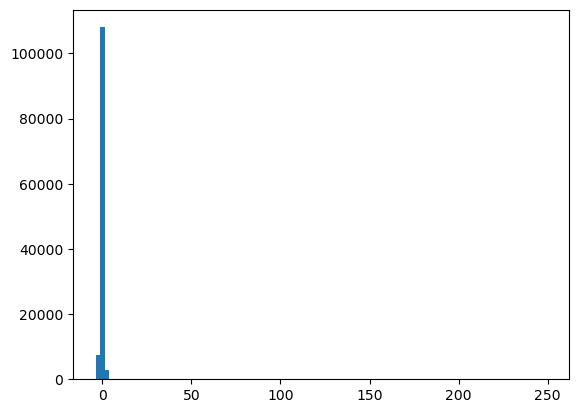

In [17]:
plt.figure()
plt.hist(kiba['binding_affinity'], bins=100)
plt.show()

In [18]:
drug_idx = torch.tensor(kiba.drug_idx.values, dtype=torch.long)
prot_idx = torch.tensor(kiba.prot_idx.values, dtype=torch.long)

x = torch.cat([z_drug[drug_idx], z_prot[prot_idx]], dim=1)
#y = torch.tensor(kiba.binding_affinity.values, dtype=torch.float32).view(-1, 1)
y = torch.tensor(kiba['Ki , Kd and IC50  (KIBA Score)'], dtype=torch.float32)

In [19]:
with torch.no_grad(): 
    y_pred = model.cuda()(x.cuda(), samples=100).squeeze()

In [20]:
np.corrcoef(y.cpu().numpy().ravel(), y_pred.mean(0).cpu().numpy().ravel())[0,1]

0.6201885840620212

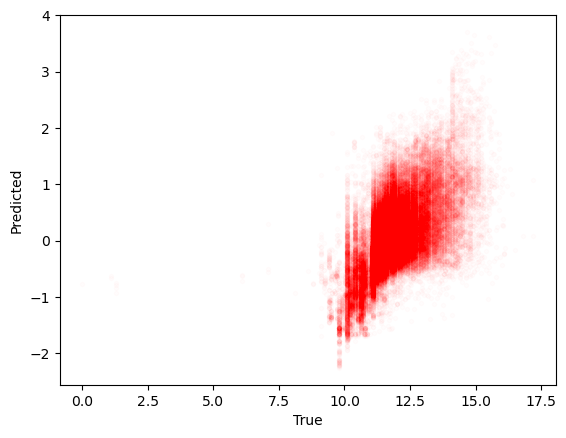

In [21]:
plt.figure()
plt.plot(y.cpu().numpy(), y_pred.mean(0).cpu().numpy(), 'r.', alpha=0.01)
#plt.xlim(-5, 5)
#plt.ylim(-5, 5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

In [22]:
affin = load_dataset("jglaser/binding_affinity",split='train[:90%]').to_pandas()

In [23]:
kiba_smiles = kiba['compound_iso_smiles'].unique() 
jglaser_smiles = affin['smiles_can'].unique()

overlap_smiles = np.intersect1d(kiba_smiles, jglaser_smiles)
len(overlap)

NameError: name 'overlap' is not defined

In [ ]:
kiba_aas = kiba['target_sequence'].unique()
jglaser_aas = affin['seq'].unique()

overlap_aas = np.intersect1d(kiba_aas, jglaser_aas)
len(overlap_aas)

224

In [ ]:
affin.head()

,seq,smiles,affinity_uM,neg_log10_affinity_M,smiles_can,affinity
0,MTVPDRSEIAGKWYVVALASNTEFFLREKDKMKMAMARISFLGEDE...,CCCCCCCCCCCCCCCCCCCC(=O)O,0.026,7.585027,CCCCCCCCCCCCCCCCCCCC(=O)O,0.691712
1,APQTITELCSEYRNTQIYTINDKILSYTESMAGKREMVIITFKSGE...,OC[C@H]1O[C@H](Oc2cccc(c2)N(=O)=O)[C@@H]([C@H]...,500.000,3.301030,O=[N+]([O-])c1cccc(O[C@H]2O[C@H](CO)[C@H](O)[C...,-2.054668
2,VETFAFQAEIAQLMSLIINTFYSNKEIFLRELISNSSDALDKIRYE...,COc1ccc(cc1)c1c(onc1c1cc(C(C)C)c(cc1O)O)NC(=O)...,0.023,7.638272,COc1ccc(-c2c(-c3cc(C(C)C)c(O)cc3O)noc2NC(=O)C2...,0.725847
3,AAPFDKSKNVAQSIDQLIGQTPALYLNKLNNTKAKVVLKMECENPM...,OC[C@@H](C(=O)N[C@@H]([C@H](CC)C)C(=O)O)NC(=O)...,6.430,5.191789,CC[C@H](C)[C@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC1...,-0.842542
4,YITFRSFTAVLIAFFLTLVLSPSFINRLRKIQRKKYTPTMGGIVIL...,CO[C@@H]1[C@H](O[C@H]([C@@H]1O)n1ccc(=O)[nH]c1...,0.185,6.732828,CO[C@@H]1[C@@H]([C@@H](O[C@H]2OC(C(=O)N[C@H]3C...,0.145386


In [ ]:
kiba.head()

,CHEMBLID,ProteinID,compound_iso_smiles,target_sequence,"Ki , Kd and IC50 (KIBA Score)",drug_idx,prot_idx,neg_lgo10_uM,binding_affinity
0,CHEMBL373751,P53350,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSAAVTAGKLARAPADPGKAGVPGVAAPGAPAAAPPAKEIPEVLVD...,0.0,0,0,23.025851,249.303756
1,CHEMBL373751,P00533,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,1.1,0,1,-0.095310,23.119186
2,CHEMBL373751,P04626,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,1.1,0,2,-0.095310,23.119186
3,CHEMBL373751,P49840,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSGGGPSGGGPGGSGRARTSSFAEPGGGGGGGGGGPGGSASGPGGT...,1.3,0,3,-0.262364,21.484966
4,CHEMBL373751,P49841,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSGRPRTTSFAESCKPVQQPSAFGSMKVSRDKDGSKVTTVVATPGQ...,1.3,0,4,-0.262364,21.484966


In [ ]:
df = affin.merge(kiba, left_on=['smiles_can', 'seq'], right_on=['compound_iso_smiles', 'target_sequence'], how='inner')
df

,seq,smiles,affinity_uM,neg_log10_affinity_M,smiles_can,affinity,CHEMBLID,ProteinID,compound_iso_smiles,target_sequence,"Ki , Kd and IC50 (KIBA Score)",drug_idx,prot_idx,neg_lgo10_uM,binding_affinity
0,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,CCCCCCCCCCCCCCCCCCOCC(COP([O-])(=O)OCC[N+](C)(...,3.5,5.455932,CCCCCCCCCCCCCCCCCCOCC(COP(=O)([O-])OCC[N+](C)(...,-0.673205,CHEMBL28509,P31749,CCCCCCCCCCCCCCCCCCOCC(COP(=O)([O-])OCC[N+](C)(...,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,11.555932,798,76,-2.447199,0.11165
